In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler

# For loading and handling images
from PIL import Image


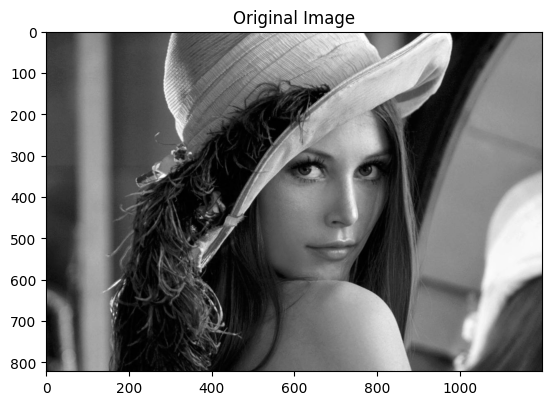

In [3]:
# Load the image and convert it to grayscale
def load_image(path):
    img = Image.open(path).convert('L')
    img = np.array(img, dtype=np.float64) / 255  # Normalize image pixels
    return img

image = load_image("/content/13549827_web1_180914-CDT-booknotes.jpg")
plt.imshow(image,cmap='gray')
plt.title("Original Image")
plt.show()


In [4]:
image.shape

(822, 1200)

In [6]:
def matrix_factorization_sgd(image, rank, steps=500, alpha=0.0002, beta=0.02,tolerance=1e-4): #optimise the steps parameter
    m, n = image.shape
    U = np.random.rand(m, rank)
    V = np.random.rand(n, rank)
    prev_loss = np.inf #can be used for stopping criterion

    non_zero = np.argwhere(image > 0)  # Indices of non-zero pixels

    for step in range(steps):
        np.random.shuffle(non_zero)  # Shuffle non-zero pixels for SGD
        for i, j in non_zero:
            eij = image[i, j] - np.dot(U[i, :], V[j, :].T)
            U[i, :] += alpha * (2 * eij * V[j, :] - beta * U[i, :])
            V[j, :] += alpha * (2 * eij * U[i, :] - beta * V[j, :])
        # # Optionally, you can add a stopping criterion based on the change in RMSE or loss
        # # Calculate the loss
        # loss = np.sum((image - np.dot(U, V.T)) ** 2) / (m * n)

        # # Check for convergence
        # if abs(prev_loss - loss) < tolerance:
        #     print(f"Converged at step {step}")
        #     break
        # prev_loss = loss

    return np.dot(U, V.T)

# rank = 50 #optimise this hyperparameter
# reconstructed_image = matrix_factorization_sgd(image, rank)

# # Plot original and reconstructed images
# plt.subplot(1, 2, 1)
# plt.imshow(image, cmap='gray')
# plt.title("Original Image")
# plt.subplot(1, 2, 2)
# plt.imshow(reconstructed_image, cmap='gray')
# plt.title("Reconstructed Image")
# plt.show()

# # RMSE and PSNR
# rmse_value = np.sqrt(mean_squared_error(image, reconstructed_image))
# psnr_value = psnr(image, reconstructed_image)
# print(f"RMSE: {rmse_value}, PSNR: {psnr_value}")


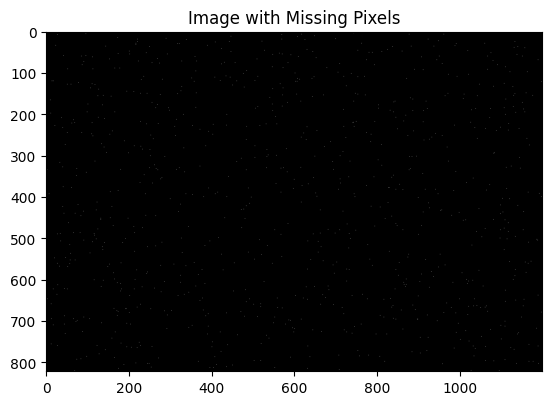

In [12]:
# # Randomly remove 900 pixels and set them to white (255) to make them more noticeable
# def remove_random_pixels(image, num_pixels=900):
#     missing_image = image.copy()
#     indices = np.random.choice(image.size, num_pixels, replace=False)

#     # Set the missing pixels to 255 (white)
#     missing_image[np.unravel_index(indices, image.shape)] = 255

#     plt.imshow(missing_image, cmap='gray')
#     plt.title("Image with Missing Pixels")
#     plt.show()

#     return missing_image, indices

# missing_image, missing_indices = remove_random_pixels(image)



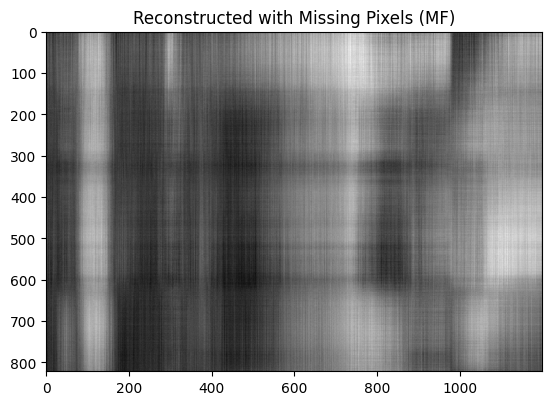

RMSE (MF): 0.15735736111121565, PSNR (MF): 16.062258723244533


In [7]:
# Randomly remove 900 pixels
def remove_random_pixels(image, num_pixels=900):
    missing_image = image.copy()
    indices = np.random.choice(image.size, num_pixels, replace=False)
    missing_image[np.unravel_index(indices, image.shape)] = 0
    plt.imshow(missing_image, cmap='gray')
    plt.title("Image with Missing Pixels")
    plt.show()
    return missing_image, indices

missing_image, missing_indices = remove_random_pixels(image)

# Reconstruct the image using matrix factorization
reconstructed_missing_image = matrix_factorization_sgd(missing_image, rank=20,steps=100)

# RMSE and PSNR for matrix factorization
rmse_missing = np.sqrt(mean_squared_error(image, reconstructed_missing_image))
psnr_missing = psnr(image, reconstructed_missing_image)

plt.imshow(reconstructed_missing_image, cmap='gray')
plt.title("Reconstructed with Missing Pixels (MF)")
plt.show()

print(f"RMSE (MF): {rmse_missing}, PSNR (MF): {psnr_missing}")


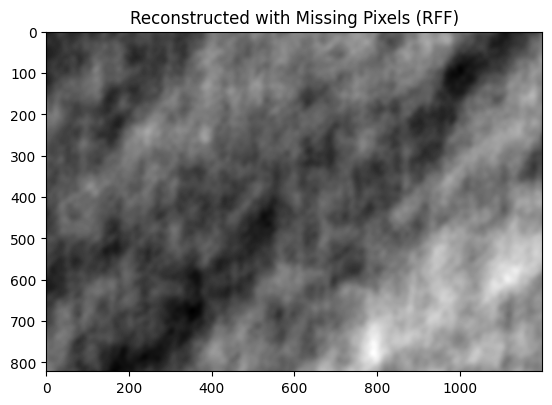

RMSE (RFF): 0.2181607428939752, PSNR (RFF): 13.224467923568655


In [15]:
# Reconstruct using RFF + Linear Regression
def rff_reconstruction(image, missing_image, num_samples=500, gamma=0.01):
    X = np.argwhere(missing_image > 0)  # Observed pixels
    y = image[missing_image > 0]

    # Apply Random Fourier Features
    rbf_sampler = RBFSampler(gamma=gamma, n_components=num_samples)
    X_features = rbf_sampler.fit_transform(X)

    # Linear Regression to fit the observed data
    reg = LinearRegression()
    reg.fit(X_features, y)

    # Predict for all pixel locations
    all_pixel_locations = np.indices(image.shape).reshape(2, -1).T
    all_features = rbf_sampler.transform(all_pixel_locations)
    reconstructed_image = reg.predict(all_features).reshape(image.shape)

    return reconstructed_image

reconstructed_rff = rff_reconstruction(image, missing_image)

# RMSE and PSNR for RFF
rmse_rff = np.sqrt(mean_squared_error(image, reconstructed_rff))
psnr_rff = psnr(image, reconstructed_rff)

plt.imshow(reconstructed_rff, cmap='gray')
plt.title("Reconstructed with Missing Pixels (RFF)")
plt.show()

print(f"RMSE (RFF): {rmse_rff}, PSNR (RFF): {psnr_rff}")


In [ ]:
print(f"RMSE (MF): {rmse_missing}, PSNR (MF): {psnr_missing}")
print(f"RMSE (RFF): {rmse_rff}, PSNR (RFF): {psnr_rff}")
